# Проверка различия кликабельности иконки Яндекс.Маркет

На главной странице Яндекса  над строкой поиска поменяли местами иконки "Маркет" и "Карты". 

**задача** - проверить повлияло ли изменение и стали ли пользователи чаще кликать на иконку "Маркета" по возвращению на сайт

**данные** - есть данные с id пользователя, сесиии, клика.


## Вывод

статистически значимых различий при альфа = 0.05 в кликабельность до и после изменений на странице не изменилась. вероятно это связано с тем, что изменения местоположения иконок слишком малозаметный тригер. пользователи идут нацелено на страницу маркета, а если им он был не нужен, то и не кликают по иконке. при альфа = 0.11 можно было бы сказать, что кликабельность после изменения уменьшилась. 

таким образом, ни при каком альфа мы не можем советовать выкатывать изменения в продакшн.

## Оглавление <a class="anchor" id="begin"></a>

* [Изучение и подготовка данных](#data)
* [Проверка кликабельности на стат. значимость](#check)
* [Интервальная оценка долей](#1)
* [ХИ-тест](#2)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import numpy as np
from statsmodels.stats.proportion import proportion_confint

In [2]:
df=pd.read_csv('case_ctr.csv', sep=';')

## Изучение и подготовка данных <a class="anchor" id="data"></a>

In [3]:
display(df.head())
display(df.info())

,Unnamed: 0,user_id,session_id,click_id,experimentVariant
0,1,4299b8c9c50c3e4e8a067f448426463e,08f9c3b0e2ff8da7bad6cc200fa735a2,56bcee80ce68ddc58c178a63288965b2,1
1,2,863829e0fc8e0dcd88f44c6a63db836a,d0ebf6ddaa8702e6de4e46854a1136ff,b209c6b14e91606a99d637ff6eb74cc6,1
2,3,640af3312483bea44b8159a8caaf0b3d,838c4a718830b5f1ac7be5e70745ff47,3f3d510c709ae5d9bae0331fcf776f3a,1
3,4,43de481cae63944b81db6fd5567a12bb,8f36aead1ceafb3e67f9957a7765549e,da73306047217a73a6ee0ea7477f2ad7,0
4,5,b84dd1a6c3df2e08eb7bef496cdf6d39,09799cdf1394b0e4b86ace899b7f218e,6e4b93932be600a5536c291888996037,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         10000 non-null  int64 
 1   user_id            10000 non-null  object
 2   session_id         10000 non-null  object
 3   click_id           7655 non-null   object
 4   experimentVariant  10000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 390.8+ KB


None

2345 раза пользователи не нажали на иконку маркета

проверим данные на аномалии

In [4]:
df_grouped=df.groupby('user_id', 
                      as_index=False).agg({'session_id':'count', 
                                           "click_id":'count',
                                           'experimentVariant':'max'})

In [5]:
'''
функция строит распределение по пользователям
'''
def scatter(y, title):
    plt.figure(figsize=(15,4))
    sns.scatterplot(data=df_grouped, 
                    x='user_id', 
                    y=y, 
                    hue='experimentVariant')
    plt.xticks('')
    plt.title(f'Распределение количества {title}')
    plt.ylabel(f'Количество {title}')
    plt.xlabel('Пользователь')
    None

95%, 98%, 99% перцентиль количества сессий = [ 9. 10. 11.]
95%, 98%, 99% перцентиль количества кликов = [7. 8. 9.]


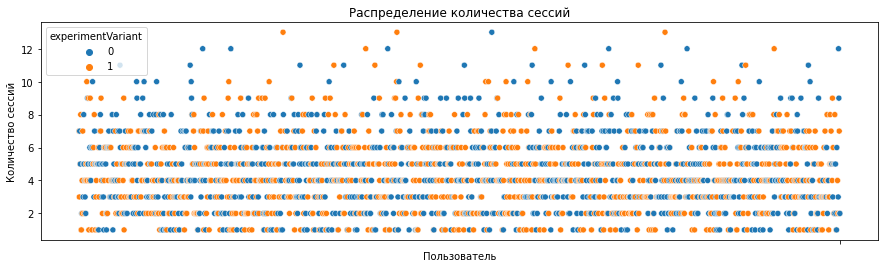

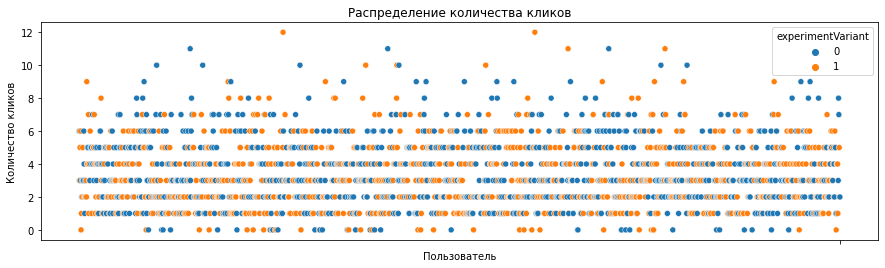

In [6]:
scatter('session_id','сессий')
scatter('click_id','кликов')

percent=np.percentile(df_grouped['session_id'], [95, 98, 99])
print(f'95%, 98%, 99% перцентиль количества сессий = {percent}')
percent=np.percentile(df_grouped['click_id'], [95, 98, 99])
print(f'95%, 98%, 99% перцентиль количества кликов = {percent}')

нет пользователей попавших в обе группы сразу. количество сессий равных 0 нет, но количество сессий больше 10 на пользователя и количество кликов больше 8 на пользователя встречается очень редко, удалим их как выбросы

In [7]:
del_user=df_grouped[df_grouped['click_id']<=8]['user_id']
df=df[df['user_id'].isin(del_user)]
print(f'всего строк удалено = {10000-df.shape[0]}, это {(10000-df.shape[0])/10000*100}%')

всего строк удалено = 365, это 3.65%


проверим данные на нормальность тестом Шапиро-Уилка

In [8]:
df_grouped=df_grouped[df_grouped['click_id']<=8]
alpha = 0.05  
results = st.shapiro(df_grouped['click_id'])
p_value = results[1] 

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  4.445334738914212e-26
Отвергаем нулевую гипотезу: распределение не нормально


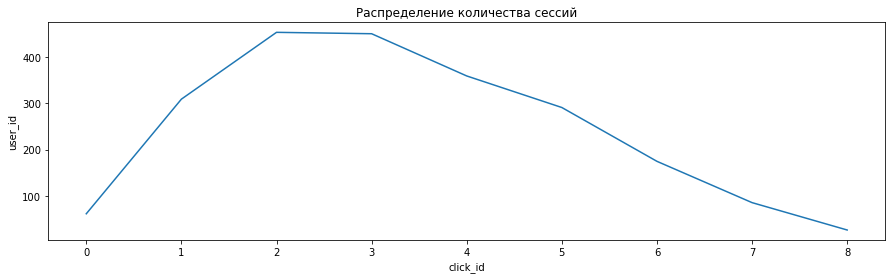

In [9]:
clicks=df_grouped.groupby('click_id', 
                          as_index=False).agg({'user_id':'count'})

plt.figure(figsize=(15,4))
sns.lineplot(data=clicks, y='user_id', x='click_id')
plt.title(f'Распределение количества сессий')
None

данные сильно скошены вправо, для проверки стат значимости будем использовать тест хи-квадрат

## Проверка кликабельности на стат. значимость  <a class="anchor" id="check"></a>

### Интервальная оценка долей  <a class="anchor" id="1"></a>

In [10]:
df=df.rename(columns={'Unnamed: 0':'index'})
df['click']=df['click_id'].astype('bool')
data=df.pivot_table(index='index', 
                    columns='experimentVariant', 
                    values='click_id', 
                    aggfunc='count').reset_index(drop=True)
data=data.fillna(0)
data[[0, 1]]=data[[0, 1]].astype('int8')
display(data.head())
display(data.describe())

experimentVariant,0,1
0,0,1
1,0,1
2,0,1
3,1,0
4,0,1


experimentVariant,0,1
count,9635.000000,9635.000000
mean,0.390140,0.370005
std,0.487807,0.482831
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


доля кликов после изменения чуть меньше, чем до. проверим различия с помощью интервальной оценки

In [11]:
conf_interval_a=proportion_confint(sum(data[0]), data.shape[0], 
                                   method='beta',alpha=0.05)
conf_interval_b=proportion_confint(sum(data[1]), data.shape[0], 
                                   method='beta',alpha=0.05)

print(f'интервал долей до изменений {conf_interval_a}')
print(f'интервал долей после изменений {conf_interval_b}') 

интервал долей до изменений (0.38038291027173, 0.39996377627669233)
интервал долей после изменений (0.36035340636856383, 0.37973561667275313)


интервалы не пересекаются, но очень близки, (пересекаются при альфа=0.04) поэтому быть абсолютно уверенными, что доли в группах отличаются мы не можем.

### ХИ-тест  <a class="anchor" id="2"></a>

In [12]:
a=df[df['experimentVariant']==0]
b=df[df['experimentVariant']==1]

a_cnt=a.shape[0]
b_cnt=b.shape[0]
a_cnt_click=a['click_id'].count()
b_cnt_click=b['click_id'].count()
ctr_a=a_cnt_click/a_cnt  #доля строк  кликов
ctr_b=b_cnt_click/b_cnt

print(f'доля строк с кликами в группе А = {round(ctr_a, 3)}')
print(f'доля строк с кликами в группе В = {round(ctr_b, 3)}')

доля строк с кликами в группе А = 0.767
доля строк с кликами в группе В = 0.753


группы разделены в пропорции 51/49, что может вызвать небольшой перекос в результатах. доля кликов после изменений уменьшилась на 1.4%, на первый взгляд это не много.

In [13]:
df_test=pd.DataFrame([[a_cnt_click, b_cnt_click],
                      [a_cnt-a_cnt_click, b_cnt-b_cnt_click]],
                    index=['есть клик', 'нет клика'],
                    columns=['A', 'B'])
df_test

,A,B
есть клик,3759,3565
нет клика,1141,1170


In [14]:
alpha=0.05
res=st.chi2_contingency(df_test)

p_value=res[1]
print(f'p_value = {p_value}')

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями кликов есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

p_value = 0.1068464563478059
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


## Вывод

статистически значимых различий при альфа = 0.05 в кликабельность до и после изменений на странице не изменилась. вероятно это связано с тем, что изменения местоположения иконок слишком малозаметный тригер. пользователи идут нацелено на страницу маркета, а если им он был не нужен, то и не кликают по иконке. при альфа = 0.11 можно было бы сказать, что кликабельность после изменения уменьшилась.

таким образом, ни при каком альфа мы не можем советовать выкатывать изменения в продакшн.